https://www.kaggle.com/ms888ekb/tesla-stocks-value-prediction-simple-lstm

1. 21 prior days will be used for prediction
2. 1 day ahead will be predicted
3. No additional model tuning will be performed
4. Target variable: open price value

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import mplfinance as mpf
plt.style.use('seaborn-deep')

In [3]:
def parse(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv('TSLA.csv',  parse_dates = True, index_col=0, date_parser=parse)
df.columns = ['Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume']
df.index.name = 'Date'

In [4]:
df.head(5)

,Open,High,Low,Close,Adj_close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
Open         2416 non-null float64
High         2416 non-null float64
Low          2416 non-null float64
Close        2416 non-null float64
Adj_close    2416 non-null float64
Volume       2416 non-null int64
dtypes: float64(5), int64(1)
memory usage: 132.1 KB


In [6]:
df.describe()

# The close and adj_close price are identical
# Drop one column

,Open,High,Low,Close,Adj_close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035003,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [7]:
print(np.var(df.Close - df.Adj_close))

0.0


In [8]:
df.drop(['Adj_close'], inplace = True, axis = 1)
c_names = [name for name in df.columns]

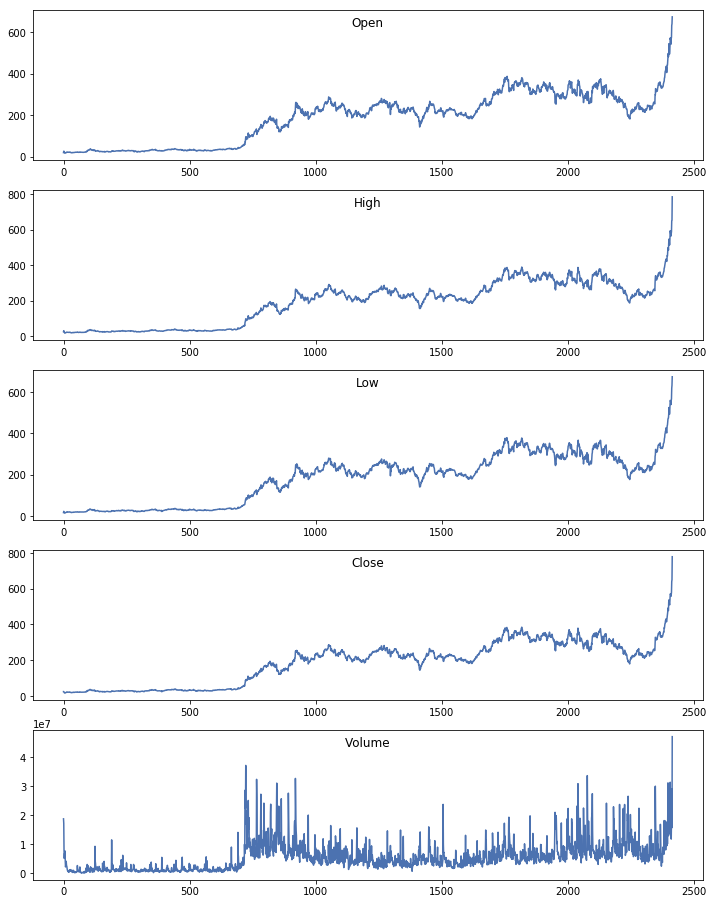

In [9]:
values = df.values

num_f = len(df.columns)

groups = [x for x in range(num_f)]

plt.figure(figsize = (12,16))

i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.85, loc='center')
    i += 1
    
plt.show()

We can observe the Tesla Stock had exploding growth in the last few days.
This behavior hasn't occured previously, and it's interesting how the LSTM will predict it.

In [10]:
def series_to_supervised(data, c_names, n_in=1, n_out=1, dropnan=True):
    '''
    This function reshape the dataset the way it can be fed to the LSTM.
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
   
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):

        cols.append(df.shift(i))
        names += ['%s(t-%d)' % (n, i) for n in c_names]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % n) for n in c_names]
        else:
            names += [('%s(t+%d)' % (n, i)) for n in c_names]
   
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
def root_mean_squared_error(y_true, y_pred):
    
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [12]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_days_back = 21
n_days_future = 1
n_features = num_f

# frame as supervised learning
reframed = series_to_supervised(scaled, c_names, n_days_back, n_days_future)

print(reframed.shape)
print(reframed.head(5))

(2395, 110)
    Open(t-21)  High(t-21)  Low(t-21)  Close(t-21)  Volume(t-21)  Open(t-20)  \
21    0.004349    0.010877   0.003887     0.010586      0.397214    0.014676   
22    0.014676    0.017920   0.012634     0.010508      0.363576    0.013474   
23    0.013474    0.012073   0.008033     0.008061      0.172543    0.010433   
24    0.010433    0.008408   0.005664     0.004449      0.106958    0.005870   
25    0.005870    0.004379   0.001291     0.000406      0.143747    0.000395   

    High(t-20)  Low(t-20)  Close(t-20)  Volume(t-20)  ...  Open(t-1)  \
21    0.017920   0.012634     0.010508      0.363576  ...   0.006707   
22    0.012073   0.008033     0.008061      0.172543  ...   0.007041   
23    0.008408   0.005664     0.004449      0.106958  ...   0.006174   
24    0.004379   0.001291     0.000406      0.143747  ...   0.006631   
25    0.000000   0.000000     0.000000      0.144914  ...   0.007391   

    High(t-1)  Low(t-1)  Close(t-1)  Volume(t-1)   Open(t)   High(t)  \
21

In [13]:
# Split training set and test set

n_obs = n_days_back * n_features

target_idx = [reframed.columns.to_list().index(col) for col in reframed.columns[n_obs:] if 'Open' in col]


# split into train and test sets
values = reframed.values

n_train_days = 2000

train = values[:n_train_days, :]
test = values[n_train_days:, :]

print(n_obs)
print(train.shape)
print(test.shape)

105
(2000, 110)
(395, 110)


In [14]:
train_X, train_y = train[:, :n_obs], train[:, target_idx]
test_X, test_y = test[:, :n_obs], test[:, target_idx]

# reshape input to fit the LSTM network requirements: [n_samples, window, n_features]
train_X = train_X.reshape((train_X.shape[0], n_days_back, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days_back, n_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 21, 5) (2000, 1) (395, 21, 5) (395, 1)


In [15]:
# design network
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_y.shape[1]))

checkpoint = ModelCheckpoint('w.hdf5', monitor='val_loss', save_best_only=True)

callback_list = [checkpoint]

model.compile(optimizer = 'adam', loss = root_mean_squared_error)

t = model.fit(train_X, train_y, epochs=50,
              batch_size=32,
              validation_data=(test_X, test_y),
              verbose=1,
              callbacks = callback_list,
              shuffle=False)

model.load_weights('w.hdf5')

Train on 2000 samples, validate on 395 samples
Epoch 1/50
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0198 - val_loss: 0.0322
Epoch 2/50
2000/2000 [==============================] - 1s 627us/step - loss: 0.0205 - val_loss: 0.0246
Epoch 3/50
2000/2000 [==============================] - 1s 651us/step - loss: 0.0110 - val_loss: 0.0191
Epoch 4/50
2000/2000 [==============================] - 1s 659us/step - loss: 0.0089 - val_loss: 0.0191
Epoch 5/50
2000/2000 [==============================] - 1s 641us/step - loss: 0.0108 - val_loss: 0.0185
Epoch 6/50
2000/2000 [==============================] - 1s 703us/step - loss: 0.0090 - val_loss: 0.0168
Epoch 7/50
2000/2000 [==============================] - 2s 855us/step - loss: 0.0076 - val_loss: 0.0162
Epoch 8/50
2000/2000 [==============================] - 1s 690us/step - loss: 0.0074 - val_loss: 0.0153
Epoch 9/50
2000/2000 [==============================] - 2s 812us/step - loss: 0.0068 - val_loss: 0.0150
Epoch 10/50
2000/20

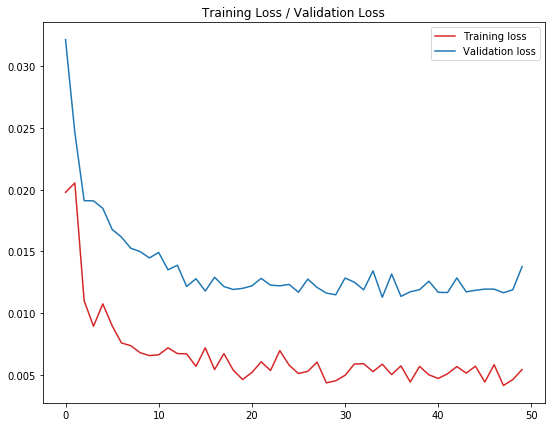

In [16]:
# plot training history

plt.figure(figsize = (9,7))
plt.title('Training Loss / Validation Loss')
plt.plot(t.history['loss'], 'tab:red', label='Training loss')
plt.plot(t.history['val_loss'], 'tab:blue', label='Validation loss')
plt.legend()
plt.show()

In [17]:
# make a prediction
yhat = model.predict(test_X)

# invert scaling
yhat_inv = yhat / scaler.scale_[0]
y_inv = test_y / scaler.scale_[0]

# reshape back
yhat_inv_rshp = yhat_inv.reshape((-1,1))
y_inv_rshp = y_inv.reshape((-1,1))

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_inv_rshp, yhat_inv_rshp))
print('Test set RMSE: %.2f' % rmse)

Test set RMSE: 8.44


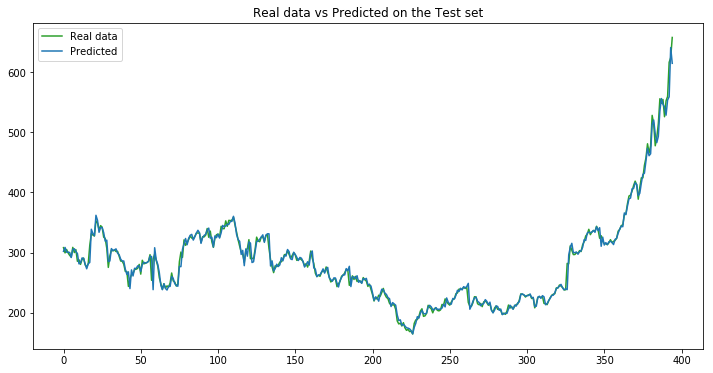

In [18]:
plt.figure(figsize = (12,6))
plt.title('Real data vs Predicted on the Test set')
plt.plot(y_inv_rshp, 'tab:green', label='Real data')
plt.plot(yhat_inv_rshp, 'tab:blue', label='Predicted')
plt.legend()
plt.show()